# Application of linear response theory method to observational data from IAP
Here, we apply the linear response theory method to observational data from IAP. This is done using the block bootstrapping methodology. We also check that the observational data meets the significant criteria found in individual_ensemble_members_CESM.ipynb which is a sufficient condition for application of the methodology.

In [1]:
import scipy.io
import netCDF4
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os, glob 
import imageio
from matplotlib import animation
import copy
import cartopy as cart
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter #see https://scitools.org.uk/cartopy/docs/v0.15/examples/tick_labels.html
import certifi
import ssl
import math
ssl._create_default_https_context = ssl._create_unverified_context
from scipy import stats
from xgcm import Grid
import statsmodels.api as sm
import matplotlib.ticker as ticker
from matplotlib.axes._secondary_axes import SecondaryAxis
import xesmf as xe
import warnings
import os

Load in observational temperature and salinity data from the Cheng et al. 2020 paper. The data can be downloaded from http://www.ocean.iap.ac.cn/pages/dataService/dataService.html

In [2]:
#Load in temperature data and then take annual mean
mean_annual_temp=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_temp=np.empty([12,180,360])
    surface_temp[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_temp_data_all/CZ16_1_2000m_Temp_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_temp_data_all/CZ16_1_2000m_Temp_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        temp=xr.open_dataset(f)['temp']
        temp=temp.where(temp<999)
        surface_temp[i-1,:,:]=temp[:,:,0]
    surface_temp=xr.DataArray(surface_temp,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_temp=surface_temp.mean('month')
    mean_annual_temp[j-1973,:,:]=surface_temp
mean_annual_temp=xr.DataArray(mean_annual_temp,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

In [3]:
#Load in salinity data and take annual mean
mean_annual_sal=np.empty([50,180,360])
for j in np.linspace(1972,2021,50):
    j=int(j)
    surface_sal=np.empty([12,180,360])
    surface_sal[:]=np.nan
    for i in np.linspace(1,12,12):
        i=int(i)
        if i<10:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_0'
        else:
            f='/scratch/abf376/IAP_salinity_data/CZ16_1_2000m_salinity_year_'
            f+=str(j)
            f+='_month_'
        f+=str(i)
        f+='.nc'
        lat = xr.open_dataset(f)['lat']
        lon = xr.open_dataset(f)['lon']
        depth_std = xr.open_dataset(f)['depth_std']
        sal=xr.open_dataset(f)['salinity']
        sal=sal.where(sal<999)
        surface_sal[i-1,:,:]=sal[:,:,0]
    surface_sal=xr.DataArray(surface_sal,dims=["month","lat","lon"],coords=[np.linspace(1,12,12),lat,lon])
    surface_sal=surface_sal.mean('month')
    mean_annual_sal[j-1973,:,:]=surface_sal 
mean_annual_sal=xr.DataArray(mean_annual_sal,dims=["year","lat","lon"],coords=[np.linspace(1972,2021,50),lat,lon])

Regrid the data

In [4]:
ds_out = xe.util.grid_global(1, 1)
regridder = xe.Regridder(mean_annual_sal, ds_out, "bilinear",periodic=True)
regrid_iap = regridder(mean_annual_sal)
regrid_iap=regrid_iap.rename({'y': 'latitude','x': 'longitude','year':'time'})
regrid_iap=regrid_iap.assign_coords(latitude=regrid_iap.lat[:,0],longitude=regrid_iap.lon[0,:])

regrid_iap_temp=regridder(mean_annual_temp)
regrid_iap_temp=regrid_iap_temp.rename({'y': 'latitude','x': 'longitude','year':'time'})
regrid_iap_temp=regrid_iap_temp.assign_coords(latitude=regrid_iap_temp.lat[:,0],longitude=regrid_iap_temp.lon[0,:])

/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [5]:
#Create area grid

import sys
sys.path.append('/scratch/abf376/freshwater_flux_linresp/tools')

from area_grid import *

area=area_grid(latitudes=np.array(regrid_iap.latitude),longitudes=regrid_iap.longitude)
area=xr.DataArray(area,dims=["latitude","longitude"],coords=[regrid_iap.latitude,regrid_iap.longitude])

In [6]:
def area_weighted_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()/((area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

Perform clustering on the observational data. Note, one of the sensitivities that we can look at is the number of clusters. Feel free to rerun this notebook with different n values. We find it has very little effect on the final results. E.g. response as a proportion of FAFMIP flux: 

NOT AREA WEIGHTED

Method with 5 clusters: 0.23737977987574746 ± 0.07548846610543089

Method with 6 clusters: 0.25483261340143 ± 0.07583697663666372

Method with 7 clusters: 0.23682707801872827 ± 0.07113287455912518

AREA WEIGHTED

Method with 5 clusters: 0.3067833707100354 ± 0.07617460683652394

Method with 6 clusters: 0.3025423993610218 ± 0.07884080903922265

Method with 7 clusters: 0.3097533708442705 ± 0.07895755348616731


1.0000000000000002e+00
(100000, 6)


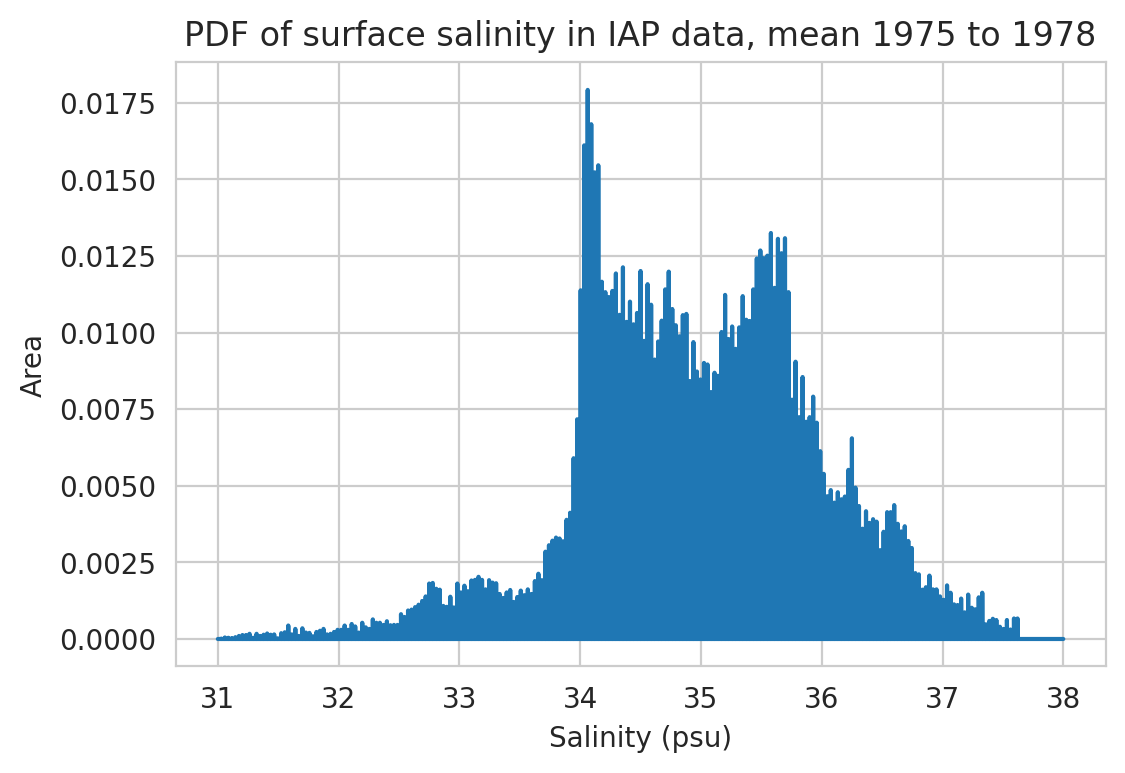

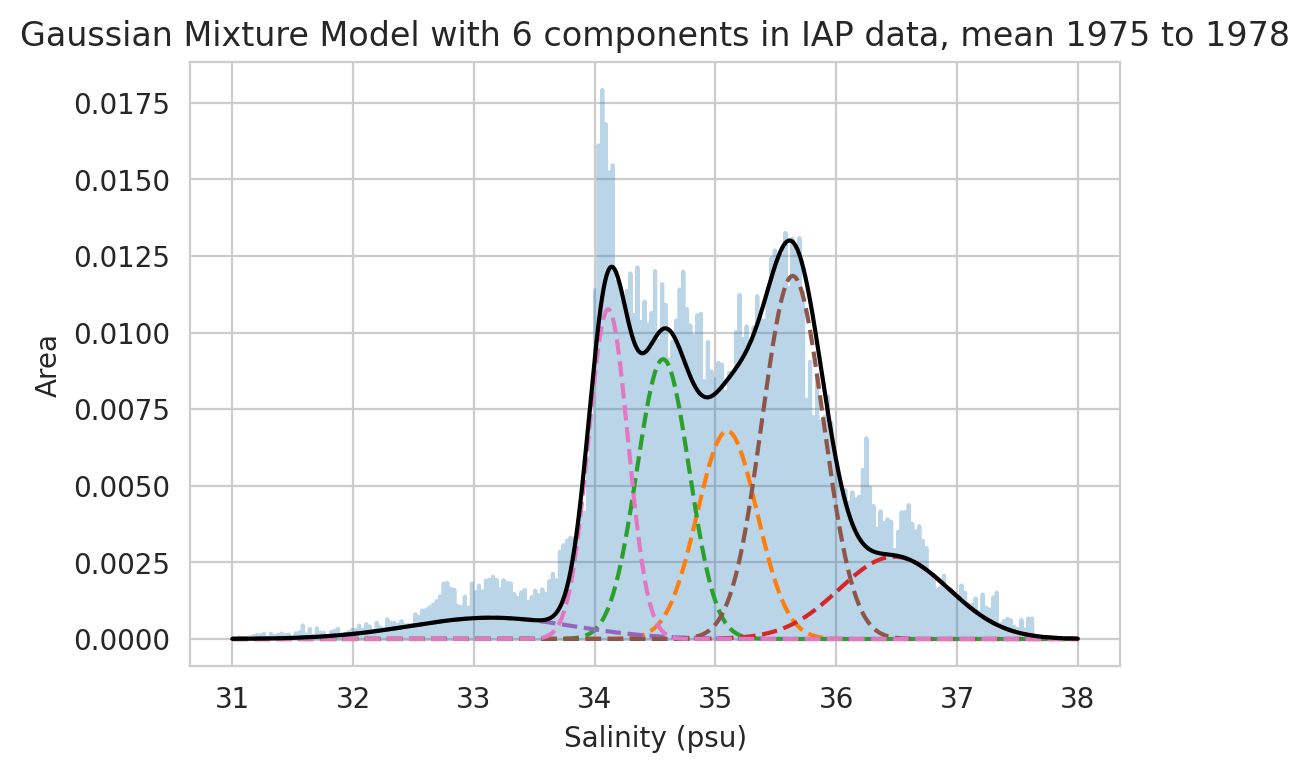

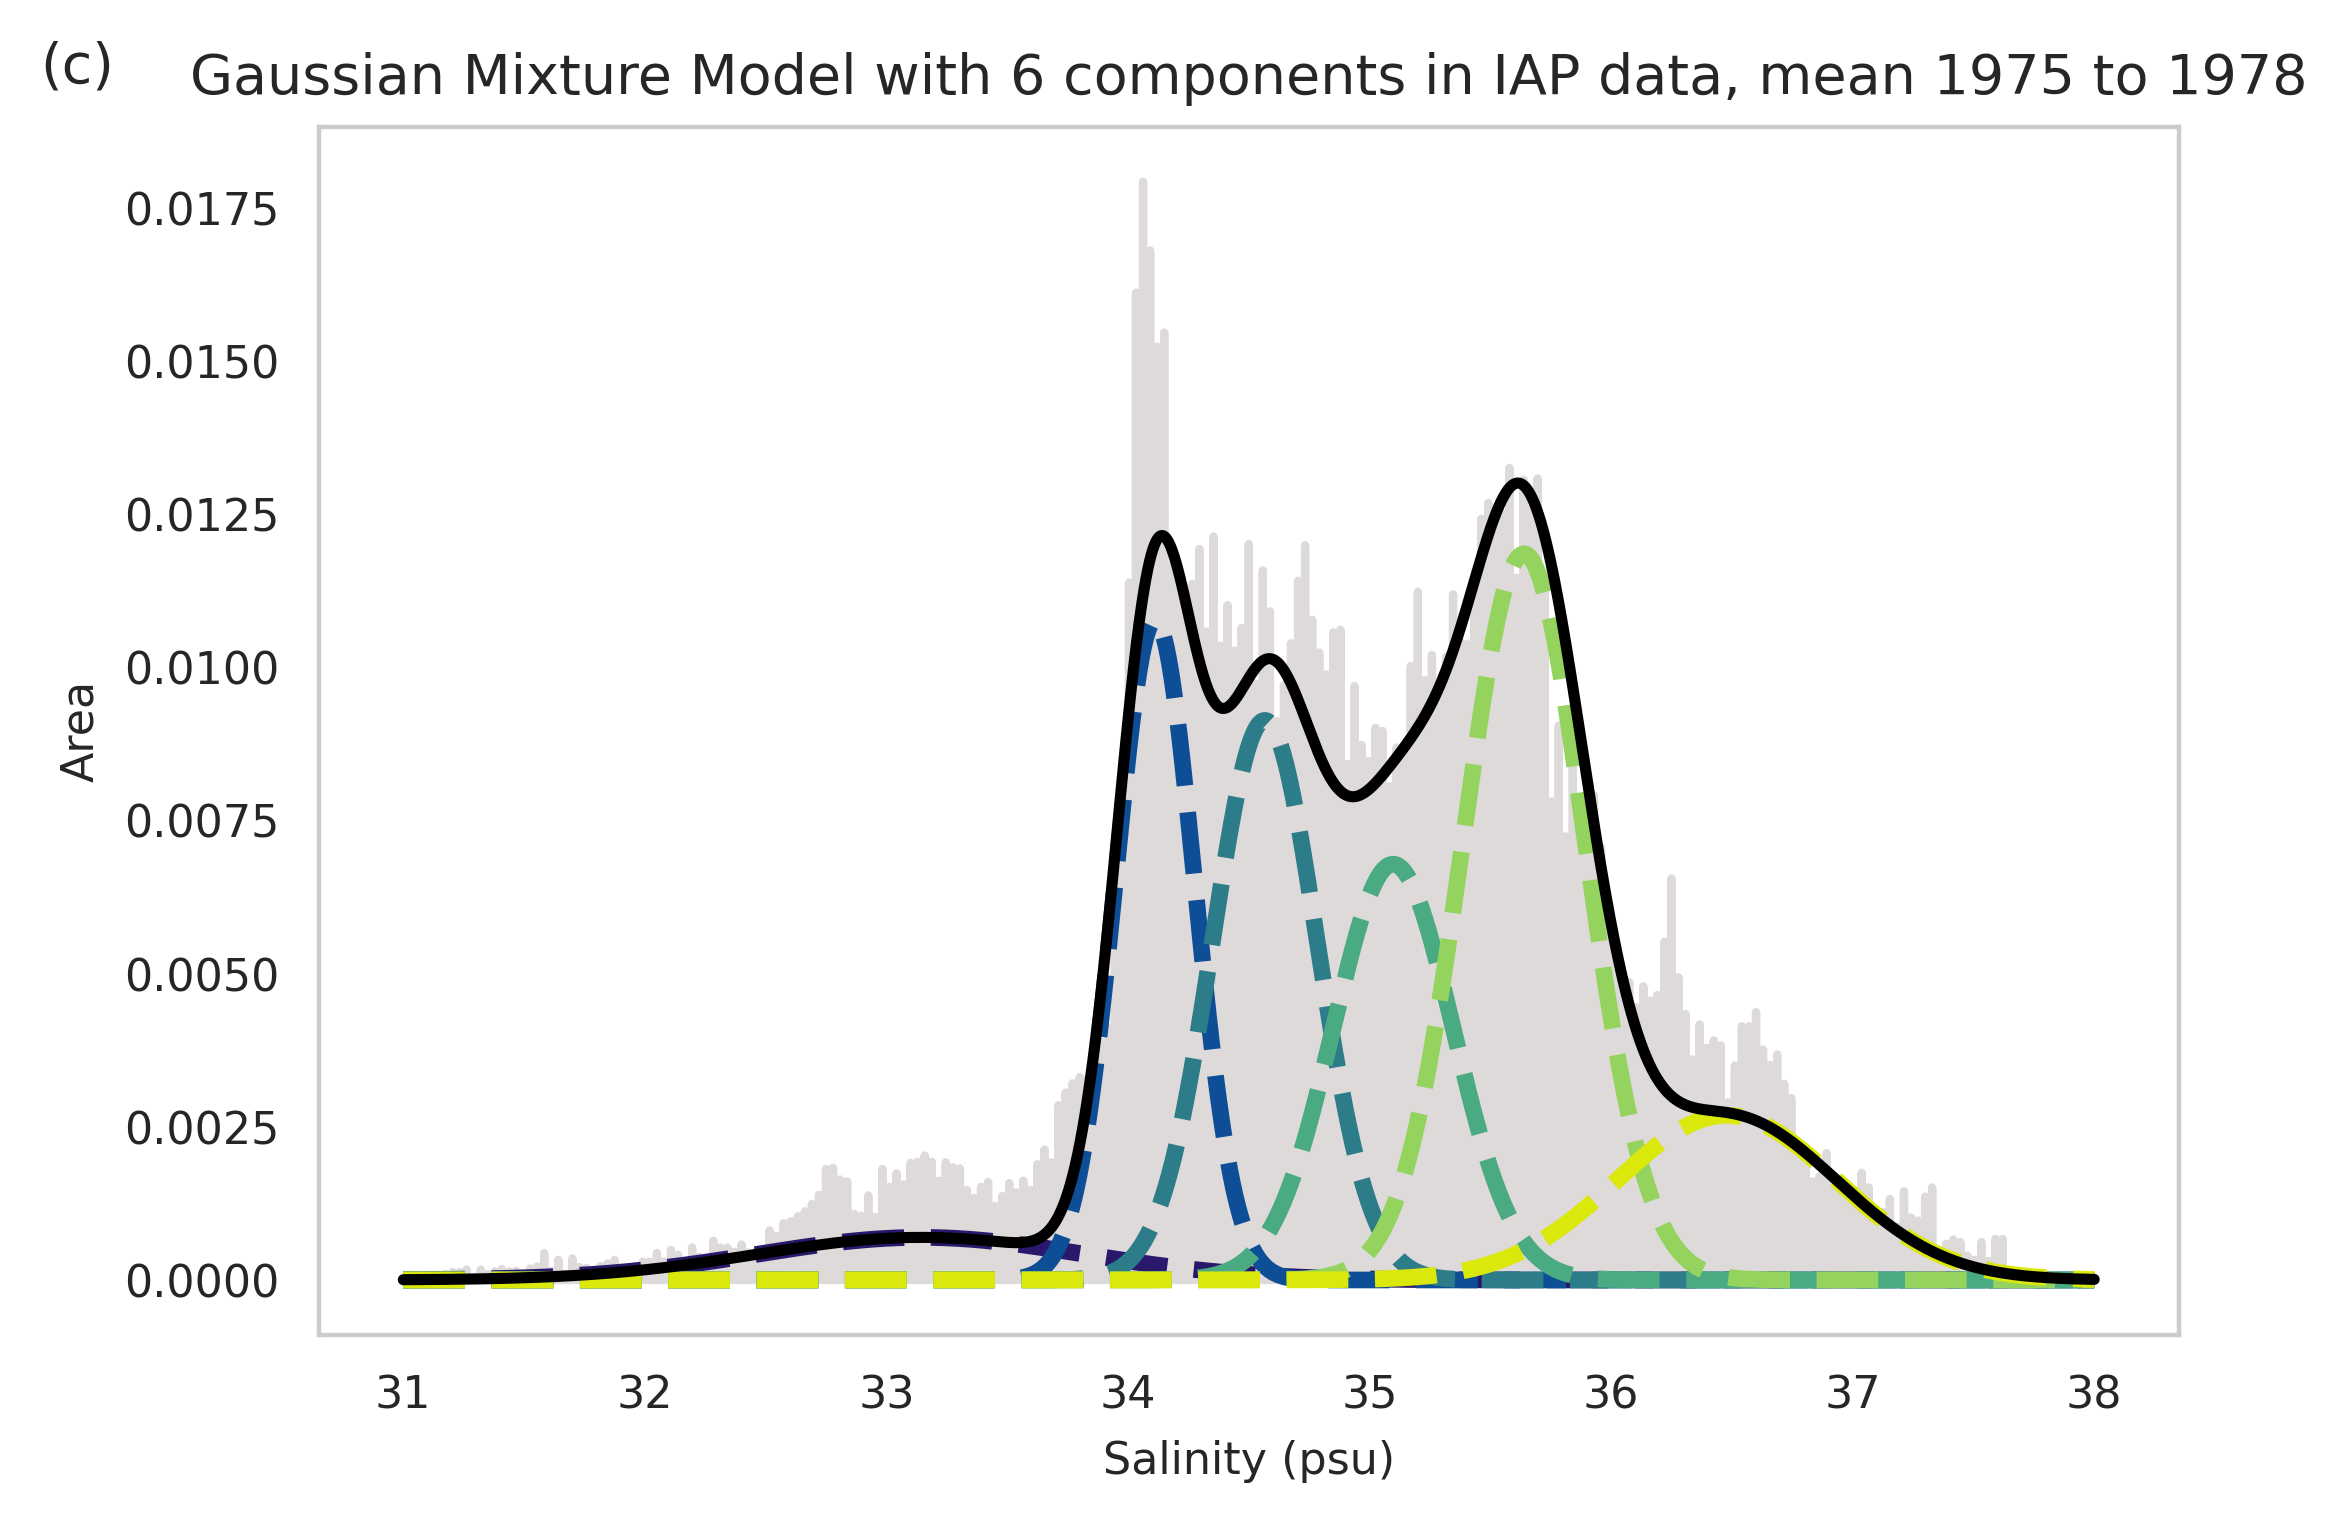

In [7]:
n=6
%load_ext autoreload 
%autoreload 2

import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

from clustering_tools import *
mean_con,sigma_con,weights_con,gm=GMM_timedep((regrid_iap[3:6].mean('time')).where(regrid_iap.latitude<65),n,'IAP data, mean 1975 to 1978',matching_paper=1,subplot_label='(c)') 

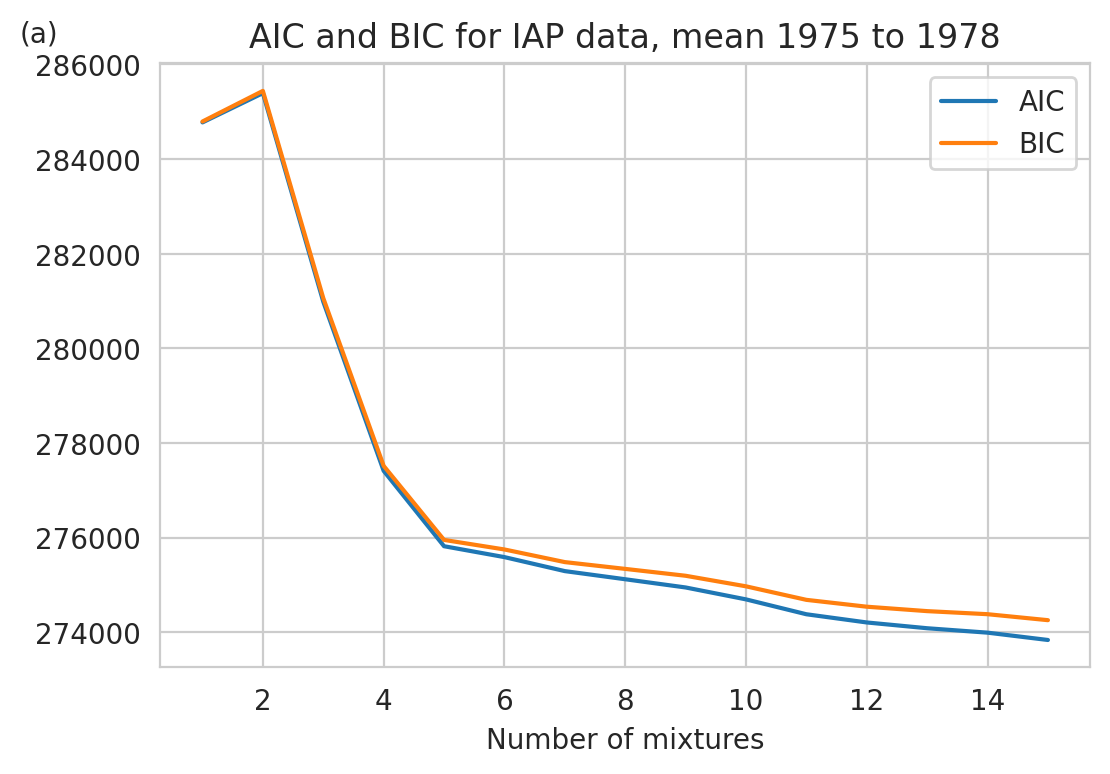

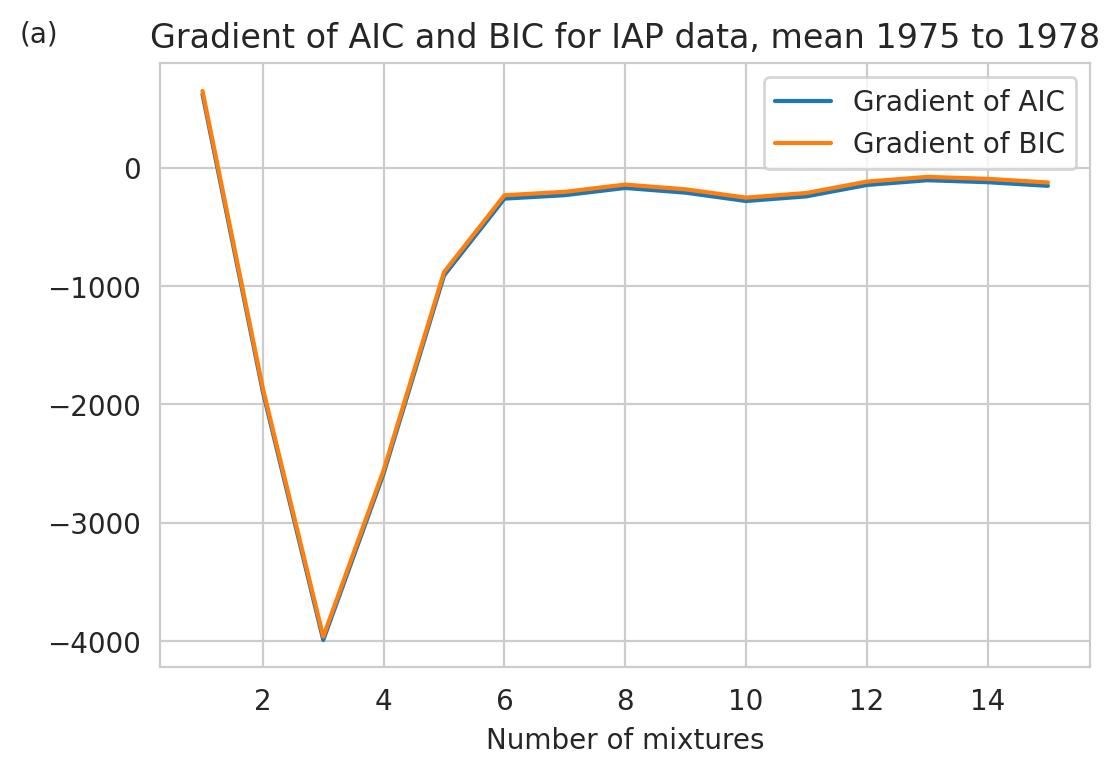

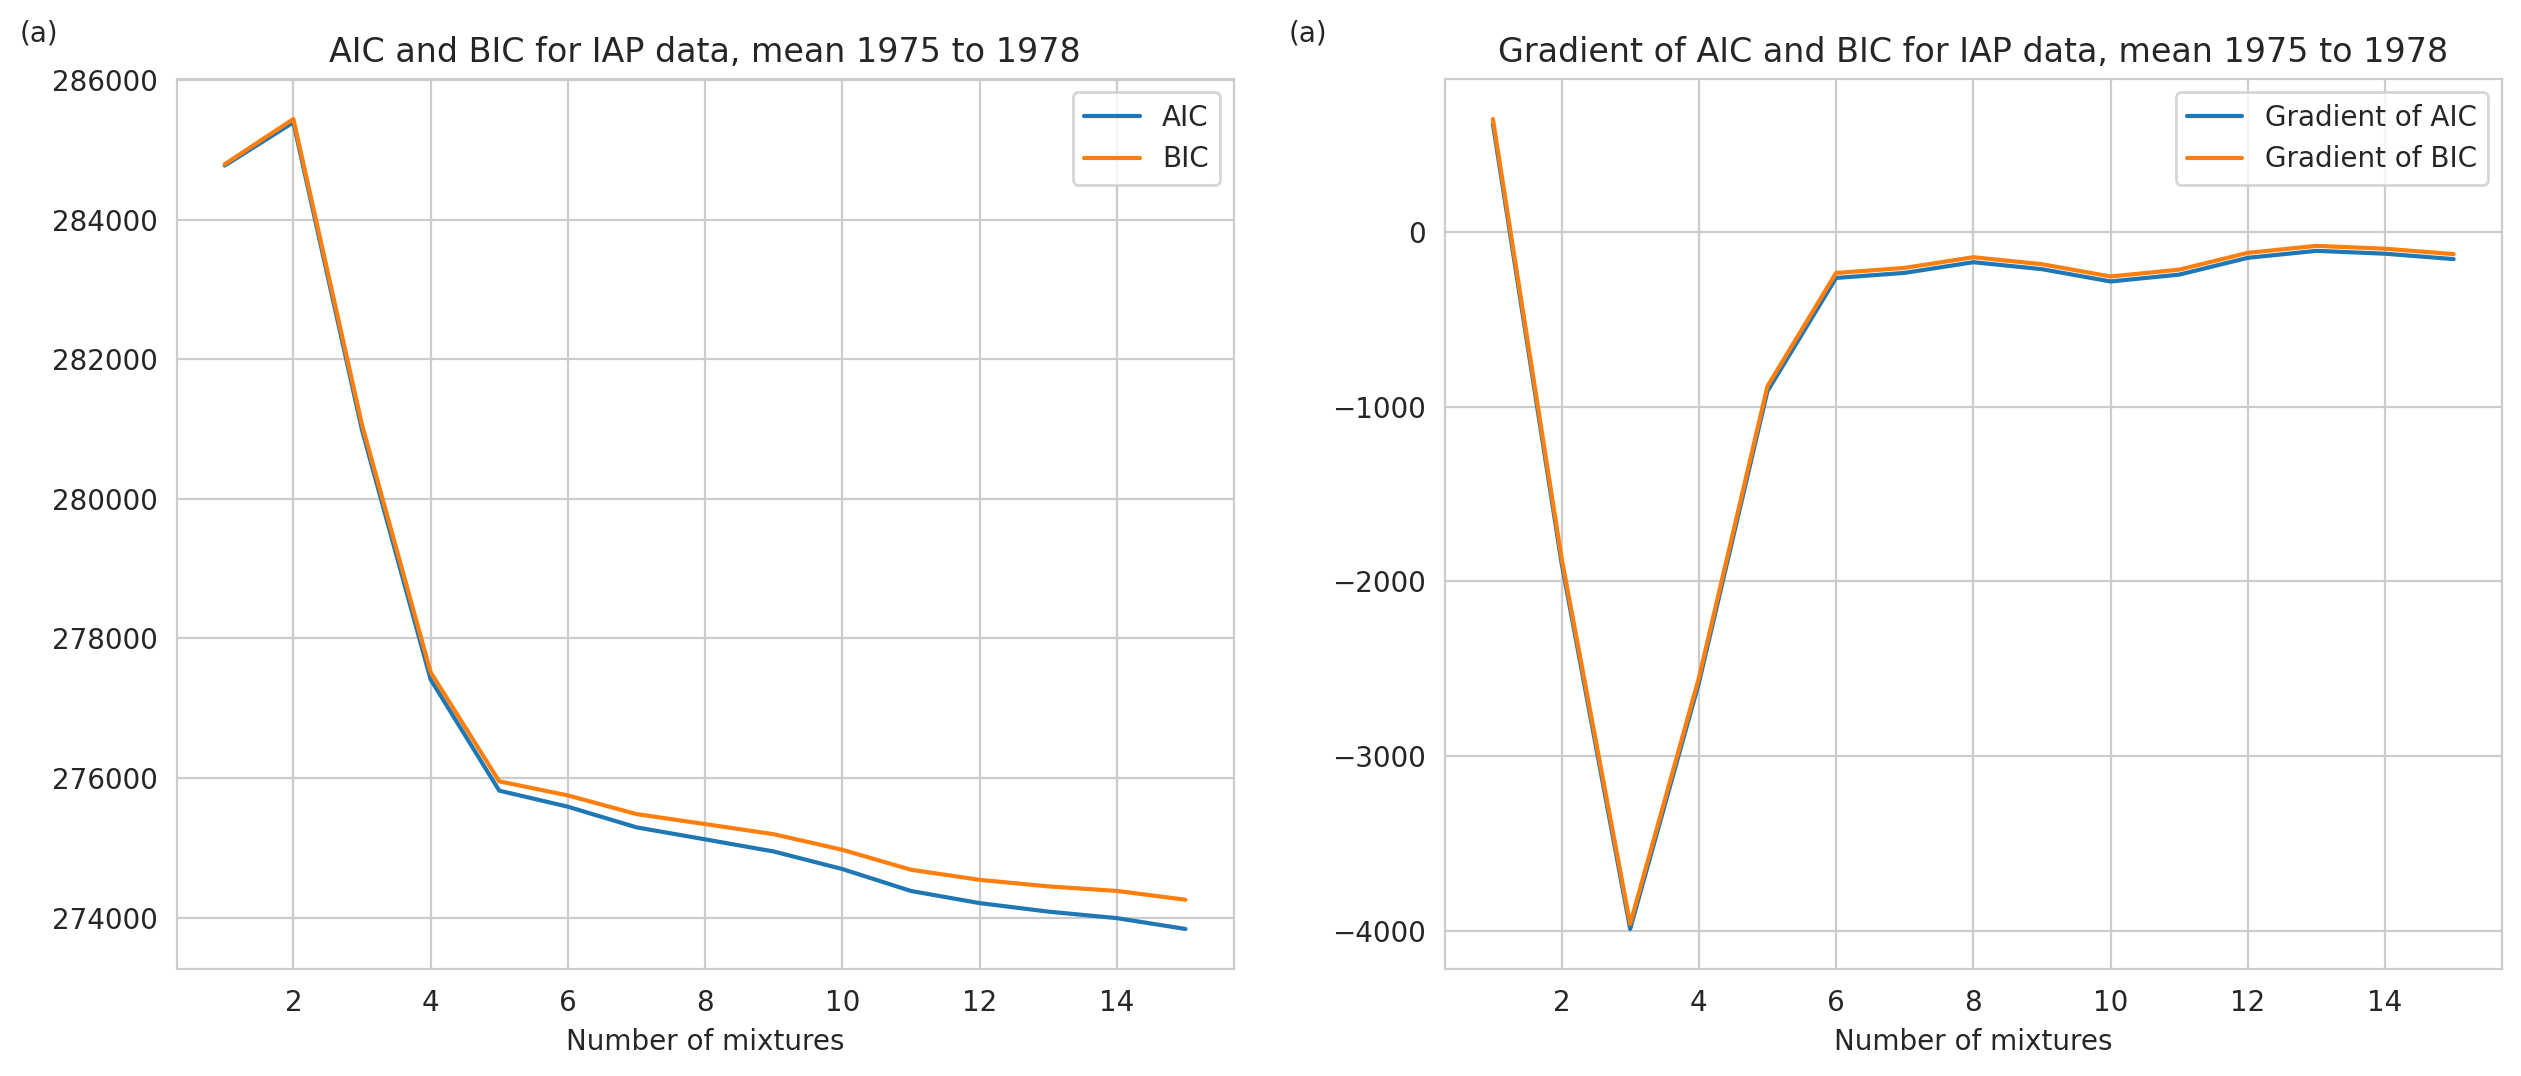

In [9]:
#Look at AIC and BIC metrics
AIC_BIC_timedep(regrid_iap[3:6].mean('time'),'IAP data, mean 1975 to 1978',subplot_label='(a)',subplot_label2='(a)')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


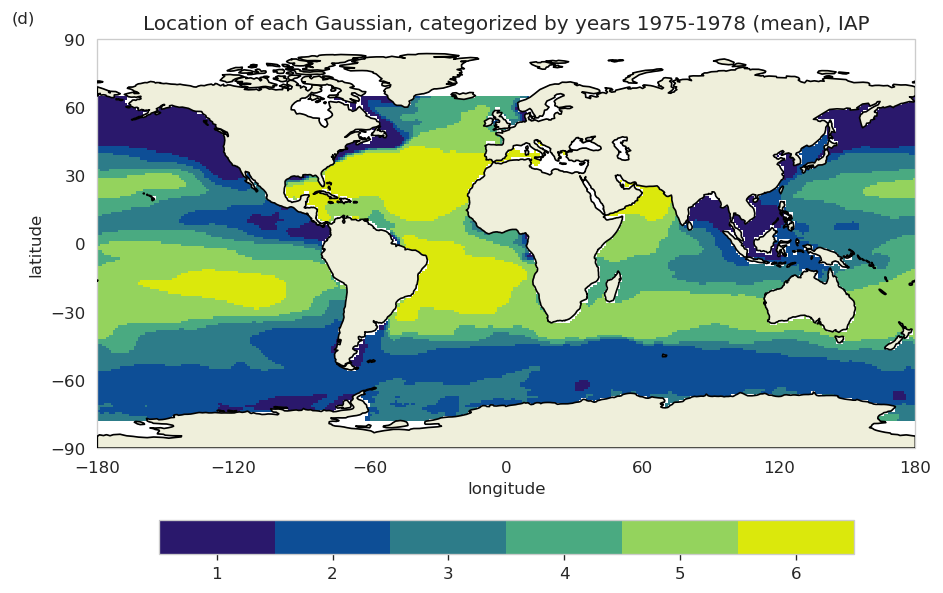

In [8]:
from clustering_tools import clusters
%load_ext autoreload
%autoreload 2
y,a2=clusters(gm,regrid_iap[3:6].mean('time'),'Location of each Gaussian, categorized by years 1975-1978 (mean), IAP',n,matching_paper=1,subplot_label='(d)')

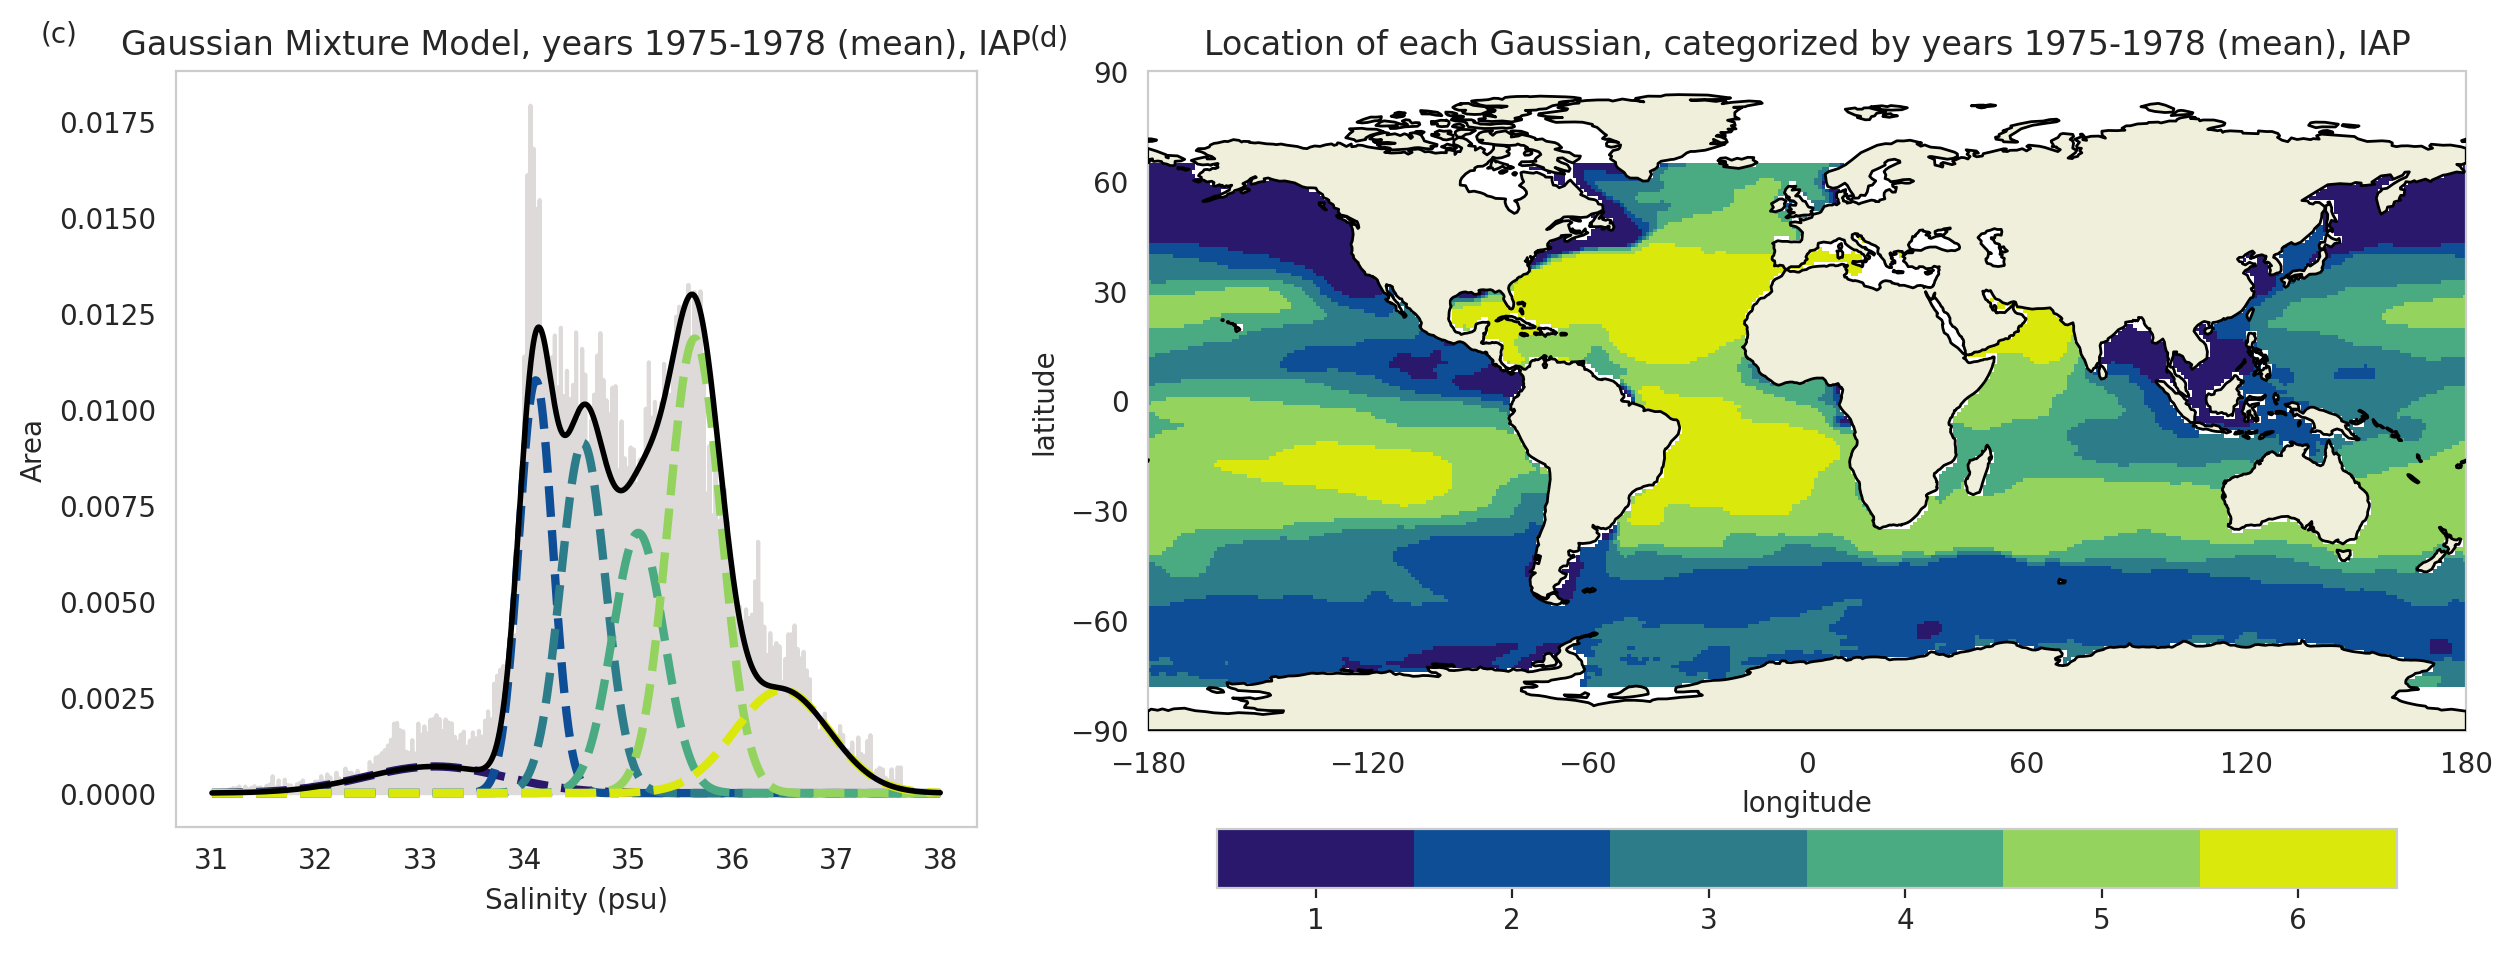

In [9]:
from clustering_tools import GMM_plot_withmap

GMM_plot_withmap((regrid_iap[3:6].mean('time')).where(regrid_iap.latitude<65),n,', years 1975-1978 (mean), IAP','Location of each Gaussian, categorized by years 1975-1978 (mean), IAP',subplot_label='(c)',subplot_label2='(d)') 


Now take the mean of salinity and temperature at each year in each cluster

In [10]:
s=(regrid_iap[3:6,:,:].mean('time')).where(regrid_iap.latitude<65)

x=np.linspace(31,38,10000)
#we have a 50 year time series, we want to find the mean salt at each region defined by the first year at each of these years
salt_iap=np.empty([50,n])
temp_iap=np.empty([50,n])
for j in range(0,50):
    s_new=(regrid_iap[j]).where(regrid_iap.latitude<65)
    t_new=(regrid_iap_temp[j]).where(regrid_iap.latitude<65)
    for i in range(0,n):
        salt_iap[j,i]=area_weighted_disjoint(area,i,s,s_new,x,a2)
        temp_iap[j,i]=area_weighted_disjoint(area,i,s,t_new,x,a2)
        
change_iap=salt_iap[:,:]-np.mean(salt_iap[3:5,:],0)
change_iap_temp=temp_iap[:,:]-np.mean(temp_iap[3:5,:],0)

change_iap=change_iap[3:48,:] #cut to the first 45 years (1975 to 2019)
change_iap_temp=change_iap_temp[3:48,:] #cut to the first 45 years (1975 to 2019)

Text(0.5, 1.0, 'Change in salinity in each region, IAP')

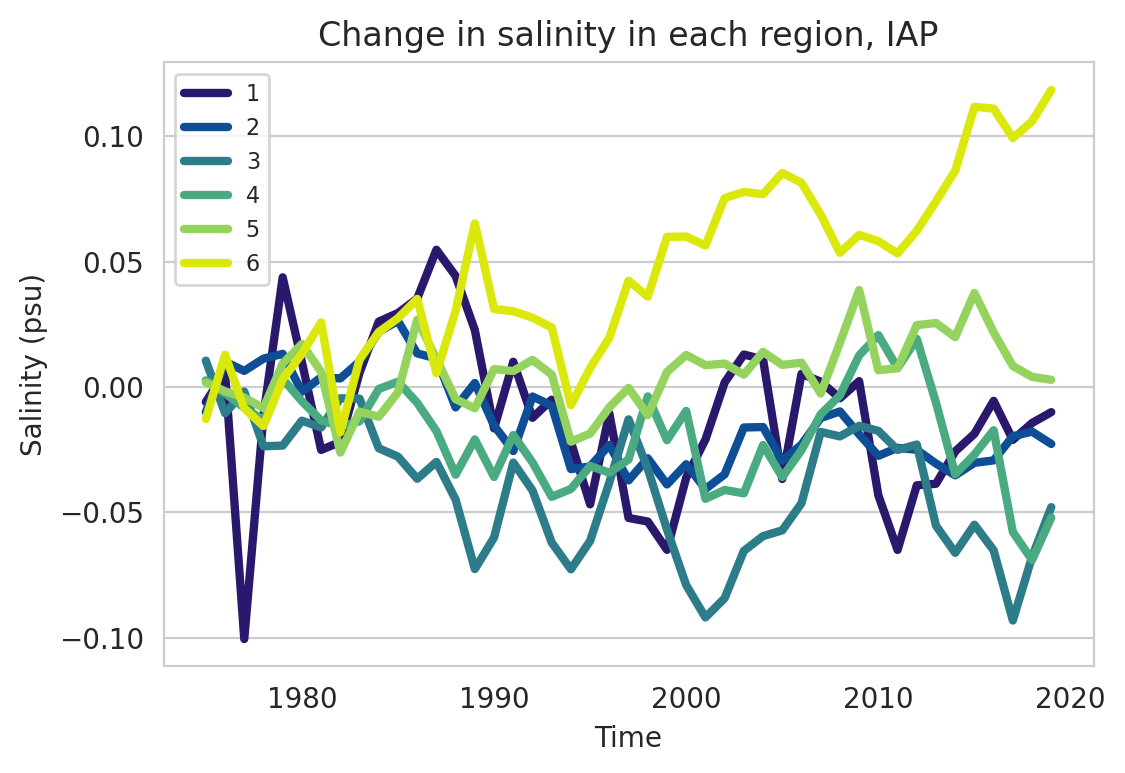

In [11]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_iap,linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, IAP')

Text(0.5, 1.0, 'Change in temperature in each region, IAP')

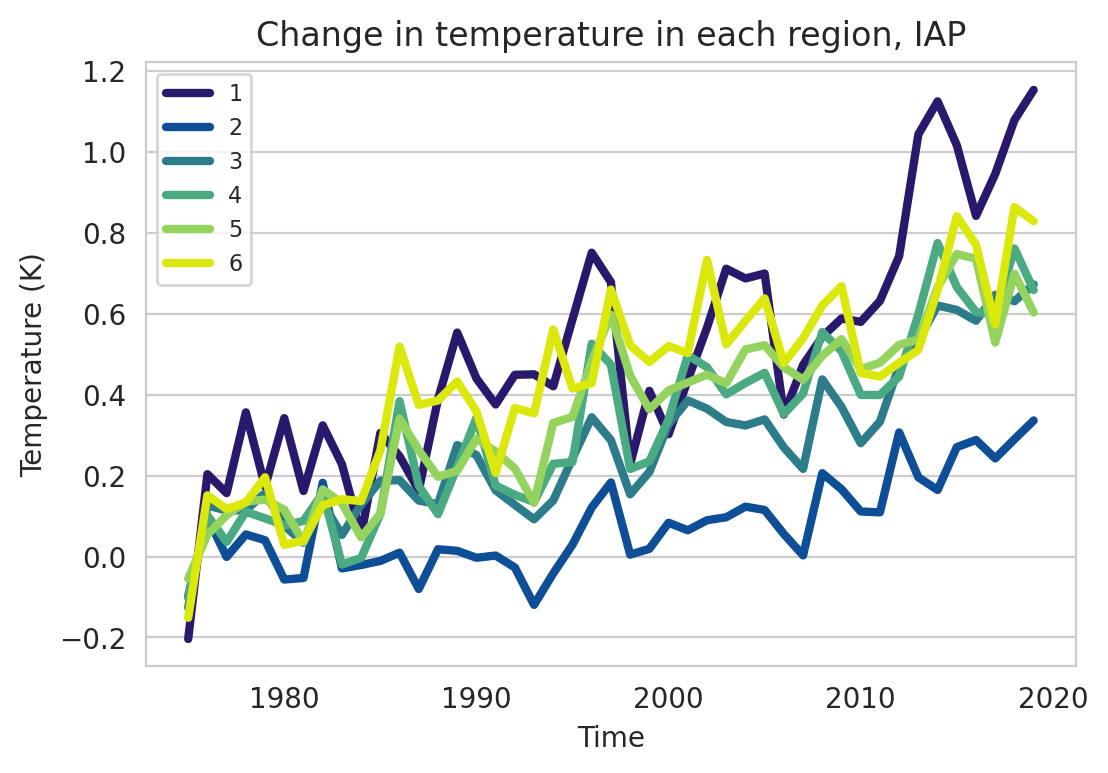

In [12]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background
fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1975,2019,45),change_iap_temp,linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Change in temperature in each region, IAP')

In [ ]:
#If we applied this without doing any enseble averaging (with the artificial ensemble)
from fafmip_gridding_tools import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(regrid_iap,area,a2,n)

from fafmip_gridding_tools import regridded_fafmip
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(regrid_iap,area,a2,n)

In [ ]:

area_weighted_1_notweighted_0=1 #choose here if you want the result to be area weighted or not
start_yr=15 #range of years after which we take the FAFMIP response
end_yr=19


df=np.zeros([50,end_yr-start_yr,3,3]) #store the [df^w/dt,df^h/dtd,df^s/dt] at each time step
df2=np.zeros([50,end_yr-start_yr,3,3]) 
df4=np.zeros([50,end_yr-start_yr,3,3])
for p in range(0,3):

    access1mit0had2=p
    for start in range(start_yr,end_yr):

        if access1mit0had2==0:
            change_water=salt_mit_water[:,:]-salt_mit_water[0,:]
            change_heat=salt_mit_heat[:,:]-salt_mit_heat[0,:]
            change_stress=salt_mit_stress[:,:]-salt_mit_stress[0,:]
            change_water_temp=temp_mit_water[:,:]-temp_mit_water[0,:]
            change_heat_temp=temp_mit_heat[:,:]-temp_mit_heat[0,:]
            change_stress_temp=temp_mit_stress[:,:]-temp_mit_stress[0,:]
        elif access1mit0had2==1:
            change_water=salt_access_water[:,:]-salt_access_water[0,:]
            change_heat=salt_access_heat[:,:]-salt_access_heat[0,:]
            change_stress=salt_access_stress[:,:]-salt_access_stress[0,:]
            change_water_temp=temp_access_water[:,:]-temp_access_water[0,:]
            change_heat_temp=temp_access_heat[:,:]-temp_access_heat[0,:]
            change_stress_temp=temp_access_stress[:,:]-temp_access_stress[0,:]
        elif access1mit0had2==2:
            change_water=salt_had_water[:,:]-salt_had_water[0,:]
            change_heat=salt_had_heat[:,:]-salt_had_heat[0,:]
            change_stress=salt_had_stress[:,:]-salt_had_stress[0,:]
            change_water_temp=temp_had_water[:,:]-temp_had_water[0,:]
            change_heat_temp=temp_had_heat[:,:]-temp_had_heat[0,:]
            change_stress_temp=temp_had_stress[:,:]-temp_had_stress[0,:]
            
        if p==2: #we smooth the hadom3 response functions
           da = xr.DataArray(change_water)
           change_water=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_heat)
           change_heat=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_stress)
           change_stress=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_water_temp)
           change_water_temp=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_heat_temp)
           change_heat_temp=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')
           da = xr.DataArray(change_stress_temp)
           change_stress_temp=da.rolling(dim_0=4,center=True).mean().dropna('dim_0')

        a=np.linalg.norm(change_iap_temp)/np.linalg.norm(change_iap)

        change2_water=np.concatenate((change_water[start:71],change_water_temp[start:71]/a),axis=1)
        change2_heat=np.concatenate((change_heat[start:71],change_heat_temp[start:71]/a),axis=1)
        if p==1:
            change2_stress=np.concatenate((change_stress[start:67],change_stress_temp[start:71]/a),axis=1)
        elif p==2:
            change2_stress=np.concatenate((change_stress[start:71],change_stress_temp[start:71]/a),axis=1)
        elif p==0:
            change2_stress=np.concatenate((change_stress[start:71],change_stress_temp[start:71]/a),axis=1)

        change_iap2_stack=np.concatenate((change_iap,change_iap_temp/a),axis=1)
        
        
        if area_weighted_1_notweighted_0==0:
            for i in range(0,44):
                sum=np.zeros(2*n)
                for j in range(0,i):
                    B=np.concatenate((np.matrix(change2_water[i-j,:]).T,np.matrix(change2_heat[i-j,:]).T,np.matrix(change2_stress[i-j,:]).T),axis=1)
                    sum=((B)*np.matrix(df[j,start-start_yr,:,p]).T).T+sum
                RHS=change_iap2_stack[i+1,:].T-sum
                A=np.concatenate((np.matrix(change2_water[0,:]).T,np.matrix(change2_heat[0,:]).T,np.matrix(change2_stress[0,:]).T),axis=1)
                x, residuals, rank, s=np.linalg.lstsq(A,np.matrix(RHS).T,rcond = -1)
                df[i,start-start_yr,:,p]=x.reshape(3)
                
        elif area_weighted_1_notweighted_0==1:
            for i in range(0,44):
                sum=np.zeros(2*n)
                for j in range(0,i):
                    B=np.concatenate((np.matrix(change2_water[i-j,:]).T,np.matrix(change2_heat[i-j,:]).T,np.matrix(change2_stress[i-j,:]).T),axis=1)
                    sum=((B)*np.matrix(df[j,start-start_yr,:,p]).T).T+sum
                RHS=change_iap2_stack[i+1,:].T-sum
                A=np.concatenate((np.matrix(change2_water[0,:]).T,np.matrix(change2_heat[0,:]).T,np.matrix(change2_stress[0,:]).T),axis=1)
                W = np.concatenate([area_cluster,area_cluster]) #this sets the weighting by the area of the cluster
                W = np.sqrt(np.diag(W))
                Aw = np.dot(W,A)
                Bw = np.dot(np.matrix(RHS),W)
                x, residuals, rank, s= np.linalg.lstsq(Aw, Bw.T,rcond = -1)
                #x, residuals, rank, s=np.linalg.lstsq(A,np.matrix(RHS).T,rcond = -1)
                df[i,start-start_yr,:,p]=x.reshape(3)


        for k in range(0,3):
            df2[:,start-start_yr,k,p]=(df[:,start-start_yr,k,p].cumsum())-(df[:,start-start_yr,k,p].cumsum())[0] #subtract off so starts from 0
        df3=np.mean(df2,axis=1) #mean over the start years where we subtracted off
df3_mean=np.mean(df3,axis=2)

fig,ax=plt.subplots(figsize=(12,6))


plt.rc('legend', fontsize=13)    # legend fontsize



plt.plot(np.linspace(1975,2019,45),df3_mean[0:45,0],linewidth=3)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,0],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,1],':',linewidth=1.5)
plt.plot(np.linspace(1975,2019,45),df3[0:45,0,2],':',linewidth=1.5)
plt.title('Freshwater flux forcing over period 1975 to 2019 (45 years) compared to FAFMIP for IAP observations',fontsize=15)
plt.xlabel('Time', fontsize=13)
plt.ylabel('F(t), proportion of FAFMIP response', fontsize=13)
plt.legend(['Mean MITgcm, ACCESS-OM2, HadOM3','MITgcm','ACCESS-OM2','HadOM3'])

## Perform block bootstrapping to generate artificial ensemble.

We also calculate the pvalues associated with block bootstrapping confidence interval so we can check if they meet significance criteria that we found in individual_ensemble_member_CESM.ipynb

In [13]:
#Get the area of each cluster
def area_disjoint(area,i,salt_surface,thing_to_weight,x,a2):
    return ((thing_to_weight*area).where(salt_surface>(x[a2[i]])).where(salt_surface<(x[a2[i+1]]))).sum()

ones_grid=regrid_iap[0,:,:].where(regrid_iap[0,:,:]==1, other=1)
area_cluster=np.empty(n)
for i in range(0,n):
    area_cluster[i]=area_disjoint(area,i,s,ones_grid,x,a2)

In [15]:
np.random.seed(0)
pvalue_bootstrap_store=np.empty([n]) #p value from block bootstrapped confidence interval


#FInd trend in each region and then block bootstrap
trend=np.empty([45,n])
pvalue_salt=np.empty([n])
for i in range(0,n):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap[:,i], alternative='two-sided')
    trend[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_salt[i]=p.pvalue



#Find the temp trend for each region and then block bootstrap
trend_temp=np.empty([45,n])
pvalue_temp=np.empty([n])
for i in range(0,n):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap_temp[:,i], alternative='two-sided')
    trend_temp[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_temp[i]=p.pvalue


from recombinator.block_bootstrap import circular_block_bootstrap

# number of replications for bootstraps (number of resampled time-series to generate)
B = 3000

y_star_cb \
    = circular_block_bootstrap(np.concatenate([change_iap-trend,change_iap_temp-trend_temp],axis=1), 
                               block_length=2, 
                               replications=B, replace=True)
bootstrap_salt=y_star_cb[:,:,0:n]
bootstrap_temp=y_star_cb[:,:,n:2*n]
#so we now have 50 "members" from performing block bootstrapping with 1 member that we had. Let's put them now in a list
salt_list_bootstrap=[]
for i in range(0,B):
    salt_list_bootstrap.append(trend+bootstrap_salt[i,:,:])

temp_list_bootstrap=[]
for i in range(0,B):
    temp_list_bootstrap.append(trend_temp+bootstrap_temp[i,:,:])
    

#store the bootstrapped p values    
bootstrapped_slope=np.empty([B,n])
for i in range(0,B):
    for j in range(0,n):
        p=scipy.stats.linregress(np.linspace(0,44,45), y=salt_list_bootstrap[i][:,j], alternative='two-sided')
        bootstrapped_slope[i,j]=p.slope

for j in range(0,n):
    z=bootstrapped_slope[:,j].mean()/bootstrapped_slope[:,j].std()
    pvalue_bootstrap_store[j] = scipy.stats.norm.sf(abs(z)) #we use this form because we expect the null hypothesis to be less than values
    

#Apply linear response theory    
from linear_response_tools import linear_response_list_bootstrap
%load_ext autoreload
%autoreload 2

#with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
 #   warnings.filterwarnings('ignore')
    ###### IF YOU WANT AREA WEIGHTED:
water_boot,heat_boot,water_boot_modelspread,heat_boot_modelspread=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,regrid_iap[3:48,:,:],n,a2,1,weighted=1,area_cluster=area_cluster,returns=4)
    ###### IF YOU DO NOT WANT AREA WEIGHTED:
    #water_boot,heat_boot=linear_response_list_bootstrap(salt_list_bootstrap,temp_list_bootstrap,regrid_iap[3:48,:,:],n,a2,1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/ext3/miniconda3/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/ext3/miniconda3/lib/python3.9/site-packages/xarray/core/dataarray.py:780: FutureWarning: elementwise comparison faile

In [16]:
pvalue_bootstrap_store

array([5.34229664e-02, 2.31726226e-08, 1.34851050e-03, 6.18962289e-02,
       1.94064401e-04, 4.17303690e-27])

In [17]:
print(water_boot.mean())
print(water_boot.std())

0.3025423993610218
0.07884080903922265


In [18]:
print(water_boot_modelspread.mean())
print(water_boot_modelspread.std())

0.3025423993610218
0.09997228369715411


In [19]:
print(heat_boot.mean())
print(heat_boot.std())

0.37614657300104704
0.09232039923350216


In [20]:
print(heat_boot_modelspread.mean())
print(heat_boot_modelspread.std())

0.3761465730010471
0.1871636112160218


## Get as a percent change per degree C

The above result is in terms of the FAFMIP perturbation. However, to compare with previous results (and with the Clausius-Clapeyron rate), we want to write this in terms of a percent amplification per degree C. To do this, we need both the change in surface air temperature over the period of interest and a measure of the climatological hydrological cycle strength. Thus, we have to introduce additional assumptions such as using choosing a data product of fluxes as the true strength of the climatological cycle. Here we choose to use the ECCO freshwater fluxes - this is because the FAFMIP perturbation includes change in river runoff and sea ice melt and so the baseline climatological estimate also needs to include this - which ECCO does. 

We quantify the total strength of the FAFMIP perturbation as the absolute value integrated and the total strength of the climatological pattern as the absolute value integrated. Thus, we do not assume that the climatological pattern necessarily projects onto the FAFMIP pattern

In [21]:
fw_fluxes=[]
for i in range(0,10):
    yr=1992+i
    for j in range(1,13):
        if j<10:
            f='/scratch/abf376/ecco_freshwater_flux_regrid/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_%d-0%d_ECCO_V4r4_latlon_0p50deg.nc' %(yr,j)
        else: 
            f='/scratch/abf376/ecco_freshwater_flux_regrid/OCEAN_AND_ICE_SURFACE_FW_FLUX_mon_mean_%d-%d_ECCO_V4r4_latlon_0p50deg.nc' %(yr,j)
        s=xr.open_dataset(f)['oceFWflx']
        fw_fluxes.append(s[0,:,:])

mean_fw_flux_92to01=sum(fw_fluxes)/len(fw_fluxes)

### Scale by choosing strength of perturbation and climatological cycle as the absolute value integrated

In [22]:
#Find the wfo strength in Sv

#water flux from fafmip
f='/scratch/abf376/FAFMIP_wfo_v2.nc' 
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
wfo = xr.open_dataset(f)['water_flux_into_sea_water']
wfo=wfo.where(wfo<1E19)

#Define area grid
from area_grid import *
area_wfo=area_grid(latitudes=np.array(wfo.latitude),longitudes=wfo.longitude)
area_wfo=xr.DataArray(area,dims=["latitude","longitude"],coords=[wfo.latitude,wfo.longitude])

rho=1000
#integrate the absolute value
watercycle_fafmip_pert=(np.abs(wfo[:,:,:].where(wfo[0,:,:].latitude<65).mean('time'))*area_wfo).sum()/(area_wfo.where(wfo[0,:,:].latitude<65).sum()) #in kg/m^2.s


#sverdrup is 1E6 m^3/s
watercycle_fafmip_pert_map_inSv=(np.abs(wfo[:,:,:].where(wfo[0,:,:].latitude<65).mean('time'))*area_wfo)/rho/1E6
watercycle_fafmip_pert_inSv=watercycle_fafmip_pert_map_inSv.sum()
print(watercycle_fafmip_pert_inSv)

<xarray.DataArray ()>
array(1.08156723)


In [23]:
#Find ECCO strength in this way

area_ecco=area_grid(latitudes=np.array(mean_fw_flux_92to01.latitude),longitudes=mean_fw_flux_92to01.longitude)

ecco_fw_flux_timesarea=(np.abs(mean_fw_flux_92to01.where(mean_fw_flux_92to01.latitude<65))*area_ecco).sum()


#sverdrup is 1E6 m^3/s
rho=1000 #kg/m^3
ecco_fw_flux_timesarea_Sv=ecco_fw_flux_timesarea/rho/1E6 #mean 1970 to 1980
print(ecco_fw_flux_timesarea_Sv)


<xarray.DataArray 'oceFWflx' ()>
array(8.05542997)


In [24]:
#Need to scale by surface air temperature 

#We can try the NASA GISS dataset https://data.giss.nasa.gov/gistemp/ where the file is https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.txt
#Let's define the temperature change as the mean of 2017 to 2021 (two years on either side of 2019) minus the mean of 1973 to 1977 (two years on either side of 1975)
Delta_SAT_GISS=((97+85+92+102+85)/5-(16-7-1-10+18)/5)/100
print(Delta_SAT_GISS)

0.89


In [25]:
obs=water_boot.mean()
std_bootstrap=water_boot.std()

print("The percent increase in the hydrological cycle is %4.3f pm %4.3f percent" %(100*obs*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv,100*std_bootstrap*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv))
print("The percent increase in the hydrological cycle is %4.3f pm %4.3f percent per degree C" %(100*obs*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv/Delta_SAT_GISS,100*std_bootstrap*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv/Delta_SAT_GISS))

The percent increase in the hydrological cycle is 4.062 pm 1.059 percent
The percent increase in the hydrological cycle is 4.564 pm 1.189 percent per degree C


In [26]:
obs=water_boot_modelspread.mean()
std_bootstrap=water_boot_modelspread.std()

print("The percent increase in the hydrological cycle is %4.3f pm %4.3f percent accounting for model error" %(100*obs*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv,100*std_bootstrap*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv))
print("The percent increase in the hydrological cycle is %4.3f pm %4.3f percent per degree C accounting for model error" %(100*obs*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv/Delta_SAT_GISS,100*std_bootstrap*watercycle_fafmip_pert_inSv/ecco_fw_flux_timesarea_Sv/Delta_SAT_GISS))

The percent increase in the hydrological cycle is 4.062 pm 1.342 percent accounting for model error
The percent increase in the hydrological cycle is 4.564 pm 1.508 percent per degree C accounting for model error


### Scale by choosing strength of perturbation and climatological cycle as projection onto perturbation
This is not the right thing to do as it then requires assuming that the climatological cycle looks like the FAFMIP perturbation and only counting strength of climatological cycle where it looks like the FAFMIP perturbation

In [ ]:
#regrid wfo and ecco
ds_out = xe.util.grid_global(1, 1)
regridder_wfo= xe.Regridder(wfo, ds_out, "bilinear",periodic=True)
wfo = regridder_wfo(wfo)
wfo=wfo.rename({'y': 'latitude','x': 'longitude'})
wfo=wfo.assign_coords(latitude=wfo.lat[:,0],longitude=wfo.lon[0,:])

regridder_ecco= xe.Regridder(mean_fw_flux_92to01, ds_out, "bilinear",periodic=True)
regrid_ecco_flux = regridder_ecco(mean_fw_flux_92to01)
regrid_ecco_flux=regrid_ecco_flux.rename({'y': 'latitude','x': 'longitude'})

In [ ]:
#now we want to compute the projection of cesm fluxes onto the fafmip perturbation field

y=np.reshape(wfo.mean('time')*area.where(area.latitude<65),(1,180*360)) #reshape the perturbation field to be a vector

x=np.reshape(regrid_ecco_flux*area.where(area.latitude<65),(1,180*360))
proj_ecco=np.nansum(x*y)/(np.nansum(y*y))
err_ecco=(np.nansum(np.abs(proj_ecco*y)))/(np.nansum(np.abs(x-proj_ecco*y))) #portion of salt flux explained by projection divided by proportion of salt flux explained by rejection. come back to this

In [ ]:
print(100*obs/proj_ecco/Delta_SAT_GISS)
print(100*std_bootstrap/proj_ecco/Delta_SAT_GISS)

## Let's calculate the W/m^2 change for the heat flux

In [ ]:
#water flux from fafmip
f='/scratch/abf376/FAFMIP_hfds_v2.nc' #this is the first 50 years
file2read = netCDF4.Dataset(f,'r')
#print(file2read.variables)
hfds = xr.open_dataset(f)['surface_downward_heat_flux_in_sea_water']
hfds=hfds.where(hfds<1E19)

In [ ]:
hfds_fafmip_pert=((hfds[:,:,:].where(hfds[0,:,:].latitude<65).mean('time'))*area_wfo).sum()/(area_wfo.where(hfds[0,:,:].latitude<65).sum()) #in W/m^2





print(hfds_fafmip_pert)
print(0.37614657300104704*hfds_fafmip_pert) #this is the block bootstrapped proportion
print(0.09232039923350216*hfds_fafmip_pert)

## Let's do a quick check on an assumption that this paper makes - that the response of the observables (temperature and salinity in each GMM region) to wind stress, heat flux perturbation, and freshwater flux perturbation, makes up the total response. 

In [ ]:
from fafmip_gridding_tools import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(regrid_iap,area,a2,n)

from fafmip_gridding_tools import regridded_fafmip
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(regrid_iap,area,a2,n)
    
from fafmip_gridding_tools import regridded_fafmip_temp_all_control
%load_ext autoreload
%autoreload 2
with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_all,temp_had_all,temp_access_all, temp_access_con, temp_mit_con, temp_had_con=regridded_fafmip_temp_all_control(regrid_iap,area,a2,n) 
    
from fafmip_gridding_tools import regridded_fafmip_all_control
%load_ext autoreload
%autoreload 2
with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_all,salt_mom_all, salt_had_all,salt_access_all, salt_access_con, salt_had_con, salt_mit_con=regridded_fafmip_all_control(regrid_iap,area,a2,n) 

In [ ]:
#Define changes in the FAFMIP stuff (comparing to control)

#CHANGE IN MITgcm
#TEMP
change_temp_mit_stress=temp_mit_stress[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_water=temp_mit_water[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_heat=temp_mit_heat[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)
change_temp_mit_all=temp_mit_all[60:70,:].mean(axis=0)-temp_mit_con[60:70,:].mean(axis=0)

#SALT
change_salt_mit_stress=salt_mit_stress[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_water=salt_mit_water[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_heat=salt_mit_heat[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)
change_salt_mit_all=salt_mit_all[60:70,:].mean(axis=0)-salt_mit_con[60:70,:].mean(axis=0)

#CHANGE IN ACCESS
#TEMP
change_temp_access_stress=temp_access_stress[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_water=temp_access_water[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_heat=temp_access_heat[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)
change_temp_access_all=temp_access_all[60:70,:].mean(axis=0)-temp_access_con[60:70,:].mean(axis=0)

#SALT 
change_salt_access_stress=salt_access_stress[60:67,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_water=salt_access_water[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_heat=salt_access_heat[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)
change_salt_access_all=salt_access_all[60:70,:].mean(axis=0)-salt_access_con[60:70,:].mean(axis=0)


#CHANGE IN HAD
#TEMP
change_temp_had_stress=temp_had_stress[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_water=temp_had_water[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_heat=temp_had_heat[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)
change_temp_had_all=temp_had_all[60:70,:].mean(axis=0)-temp_had_con[60:70,:].mean(axis=0)

#SALT
change_salt_had_stress=salt_had_stress[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_water=salt_had_water[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_heat=salt_had_heat[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)
change_salt_had_all=salt_had_all[60:70,:].mean(axis=0)-salt_had_con[60:70,:].mean(axis=0)

In [ ]:
#Define changes in the FAFMIP stuff (last 5 years vs first 5 years)

#CHANGE IN MITgcm
#TEMP
change_temp_mit_stress=temp_mit_stress[60:70,:].mean(axis=0)-temp_mit_stress[0:5,:].mean(axis=0)
change_temp_mit_water=temp_mit_water[60:70,:].mean(axis=0)-temp_mit_water[0:5,:].mean(axis=0)
change_temp_mit_heat=temp_mit_heat[60:70,:].mean(axis=0)-temp_mit_heat[0:5,:].mean(axis=0)
change_temp_mit_all=temp_mit_all[60:70,:].mean(axis=0)-temp_mit_all[0:5,:].mean(axis=0)

#SALT
change_salt_mit_stress=salt_mit_stress[60:70,:].mean(axis=0)-salt_mit_stress[0:5,:].mean(axis=0)
change_salt_mit_water=salt_mit_water[60:70,:].mean(axis=0)-salt_mit_water[0:5,:].mean(axis=0)
change_salt_mit_heat=salt_mit_heat[60:70,:].mean(axis=0)-salt_mit_heat[0:5,:].mean(axis=0)
change_salt_mit_all=salt_mit_all[60:70,:].mean(axis=0)-salt_mit_all[0:5,:].mean(axis=0)

#CHANGE IN ACCESS
#TEMP
change_temp_access_stress=temp_access_stress[60:70,:].mean(axis=0)-temp_access_stress[0:5,:].mean(axis=0)
change_temp_access_water=temp_access_water[60:70,:].mean(axis=0)-temp_access_water[0:5,:].mean(axis=0)
change_temp_access_heat=temp_access_heat[60:70,:].mean(axis=0)-temp_access_heat[0:5,:].mean(axis=0)
change_temp_access_all=temp_access_all[60:70,:].mean(axis=0)-temp_access_all[0:5,:].mean(axis=0)

#SALT 
change_salt_access_stress=salt_access_stress[60:67,:].mean(axis=0)-salt_access_stress[0:5,:].mean(axis=0)
change_salt_access_water=salt_access_water[60:70,:].mean(axis=0)-salt_access_water[0:5,:].mean(axis=0)
change_salt_access_heat=salt_access_heat[60:70,:].mean(axis=0)-salt_access_heat[0:5,:].mean(axis=0)
change_salt_access_all=salt_access_all[60:70,:].mean(axis=0)-salt_access_all[0:5,:].mean(axis=0)


#CHANGE IN HAD
#TEMP
change_temp_had_stress=temp_had_stress[60:70,:].mean(axis=0)-temp_had_stress[0:5,:].mean(axis=0)
change_temp_had_water=temp_had_water[60:70,:].mean(axis=0)-temp_had_water[0:5,:].mean(axis=0)
change_temp_had_heat=temp_had_heat[60:70,:].mean(axis=0)-temp_had_heat[0:5,:].mean(axis=0)
change_temp_had_all=temp_had_all[60:70,:].mean(axis=0)-temp_had_all[0:5,:].mean(axis=0)

#SALT
change_salt_had_stress=salt_had_stress[60:70,:].mean(axis=0)-salt_had_stress[0:5,:].mean(axis=0)
change_salt_had_water=salt_had_water[60:70,:].mean(axis=0)-salt_had_water[0:5,:].mean(axis=0)
change_salt_had_heat=salt_had_heat[60:70,:].mean(axis=0)-salt_had_heat[0:5,:].mean(axis=0)
change_salt_had_all=salt_had_all[60:70,:].mean(axis=0)-salt_had_all[0:5,:].mean(axis=0)

In [ ]:
import seaborn as sns
import matplotlib as mpl
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

fig,ax=plt.subplots(figsize=(6,4))

ax.xaxis.grid()
ax.scatter(np.linspace(1,6,6),change_salt_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax.scatter(np.linspace(1,6,6),change_salt_mit_heat+change_salt_mit_water+change_salt_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")

ax.scatter(np.linspace(1,6,6),change_salt_had_all,color="#a65628",label="HadOM3, faf-all")
ax.scatter(np.linspace(1,6,6),change_salt_had_heat+change_salt_had_water+change_salt_had_stress,color="none",edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")

ax.scatter(np.linspace(1,6,6),change_salt_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax.scatter(np.linspace(1,6,6),change_salt_access_heat+change_salt_access_water+change_salt_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax.set_title('Change in salinity in each region (as defined by IAP clusters) for FAFMIP experiments')
ax.set_xlabel('Mixture number')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
mpl.pyplot.savefig('linearity_assumption.png', dpi=500,bbox_inches='tight')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(12,4))


sns.set(font_scale=0.8)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background



#LEFT PLOT
ax1_twin = ax1.twiny()
ax1_twin.xaxis.grid()
ax1.xaxis.grid()
ax1.scatter(mean_con,change_salt_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax1.scatter(mean_con,change_salt_mit_heat+change_salt_mit_water+change_salt_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")

ax1.scatter(mean_con,change_salt_had_all,color="#a65628",label="HadOM3, faf-all")
ax1.scatter(mean_con,change_salt_had_heat+change_salt_had_water+change_salt_had_stress,color="none",edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")

ax1.scatter(mean_con,change_salt_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax1.scatter(mean_con,change_salt_access_heat+change_salt_access_water+change_salt_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax1.set_title('Change in salinity in each region (based on IAP data) \n for FAFMIP experiments',fontsize=10)
ax1.set_xlabel('Mean salinity of mixture (psu)')
ax1.set_ylabel('Change in salinity (psu)')
ax1.legend(fontsize=7)
ax1.text(-0.13, 1.05, '(a)', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax1_twin.set_xticks(newpos)


ax1_twin.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax1_twin.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax1_twin.spines['bottom'].set_position(('outward', 36))
ax1_twin.set_xlabel('Mixture number')
ax1_twin.set_xlim(ax1.get_xlim())
ax1_twin.set_xticks(newpos)
ax1_twin.set_xticklabels(newlabel)

#RIGHT PLOT
ax2.xaxis.grid()
ax2.scatter(mean_con,change_temp_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax2.scatter(mean_con,change_temp_mit_heat+change_temp_mit_water+change_temp_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")
ax2.scatter(mean_con,change_temp_had_all,color="#a65628",label="HadOM3, faf-all")
ax2.scatter(mean_con,change_temp_had_heat+change_temp_had_water+change_temp_had_stress,color='none', edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")
ax2.scatter(mean_con,change_temp_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax2.scatter(mean_con,change_temp_access_heat+change_temp_access_water+change_temp_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax2.set_title('Change in temperature in each region (based on IAP data) \n for FAFMIP experiments',fontsize=10)
ax2.set_xlabel('Mean salinity of mixture (psu)')
ax2.set_ylabel('Change in temperature (K)')
ax2.legend(fontsize=7)
ax2.text(-0.13, 1.05, '(b)', horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes)

ax2_twin = ax2.twiny()
ax2_twin.xaxis.grid()
ax2_twin.set_xticks(newpos)
ax2_twin.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2_twin.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2_twin.spines['bottom'].set_position(('outward', 36))
ax2_twin.set_xlabel('Mixture number')
ax2_twin.set_xlim(ax2.get_xlim())
ax2_twin.set_xticks(newpos)
ax2_twin.set_xticklabels(newlabel)
mpl.pyplot.savefig('linearity_assumption_dual.png', dpi=500,bbox_inches='tight')

In [ ]:
print(np.linalg.norm(change_salt_mit_heat+change_salt_mit_water+change_salt_mit_stress)/np.linalg.norm(change_salt_mit_all))
print(np.linalg.norm(change_salt_access_heat+change_salt_access_water+change_salt_access_stress)/np.linalg.norm(change_salt_access_all))
print(np.linalg.norm(change_salt_had_heat+change_salt_had_water+change_salt_had_stress)/np.linalg.norm(change_salt_had_all))

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))

ax.xaxis.grid()

ax.scatter(np.linspace(1,6,6),change_temp_mit_all,color="#377eb8",label="MITgcm, faf-all")
ax.scatter(np.linspace(1,6,6),change_temp_mit_heat+change_temp_mit_water+change_temp_mit_stress,color='none', edgecolors="#377eb8", label="MITgcm, faf-stress+faf-water+faf-heat")

ax.scatter(np.linspace(1,6,6),change_temp_had_all,color="#a65628",label="HadOM3, faf-all")
ax.scatter(np.linspace(1,6,6),change_temp_had_heat+change_temp_had_water+change_temp_had_stress,color='none', edgecolors="#a65628", label="HadOM3, faf-stress+faf-water+faf-heat")

ax.scatter(np.linspace(1,6,6),change_temp_access_all,color="#999999",label="ACCESS-OM2, faf-all")
ax.scatter(np.linspace(1,6,6),change_temp_access_heat+change_temp_access_water+change_temp_access_stress,color="none",edgecolors="#999999", label="ACCESS-OM2, faf-stress+faf-water+faf-heat")
ax.set_title('Change in temperature in each region (as defined by IAP clusters) for FAFMIP experiments')
ax.set_xlabel('Mixture number')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
mpl.pyplot.savefig('linearity_assumption_temperature.png', dpi=500,bbox_inches='tight')

In [ ]:
print(np.linalg.norm(change_temp_mit_heat+change_temp_mit_water+change_temp_mit_stress)/np.linalg.norm(change_temp_mit_all))
print(np.linalg.norm(change_temp_access_heat+change_temp_access_water+change_temp_access_stress)/np.linalg.norm(change_temp_access_all))
print(np.linalg.norm(change_temp_had_heat+change_temp_had_water+change_temp_had_stress)/np.linalg.norm(change_temp_had_all))

Now let's look at the change in each region due to each kind of forcing

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_had_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_had_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_had_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in salinity in each region for FAFMIP experiments, HadOM3', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_hadom3_iap_clusters_new.png', dpi=500,bbox_inches='tight')

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_access_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_access_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_access_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, ACCESS-OM2', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_access_iap_clusters_new_temp.png', dpi=500,bbox_inches='tight')

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_mit_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_mit_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_mit_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, MITgcm', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_mitgcm_iap_clusters_new_temp.png', dpi=500,bbox_inches='tight')

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_temp_had_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_temp_had_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_temp_had_stress,color="#DAA609",label="faf-stress")

# Set scond x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()


# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())

ax.set_title('Change in temperature in each region for FAFMIP experiments, HadOM3', fontsize=10)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in temperature (K)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_had_iap_clusters_new_temp.png', dpi=500,bbox_inches='tight')

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_access_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_access_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_access_stress,color="#DAA609",label="faf-stress")


# Set second x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()

# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())



ax.set_title('Change in salinity in each region for FAFMIP experiments, ACCESS-OM2', fontsize=9.5)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_access_iap_clusters_new.png', dpi=500,bbox_inches='tight')

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))
sns.set(font_scale=0.9)
sns.set_style(style="whitegrid") #comment out if don't want seaborn background

ax.xaxis.grid()

ax.scatter(mean_con,change_salt_mit_heat,color="#9E1212",label="faf-heat")
ax.scatter(mean_con,change_salt_mit_water,color="#055296",label="faf-water")
ax.scatter(mean_con,change_salt_mit_stress,color="#DAA609",label="faf-stress")


# Set second x-axis
ax2 = ax.twiny()
ax2.xaxis.grid()

# Decide the ticklabel position in the new x-axis,
newlabel = [1,2,3,4,5,6] # labels of the xticklabels: the position in the new x-axis
sal_tomix = lambda t: mean_con[t-1] # convert function: from salinity to mixture number
newpos   = [sal_tomix(t) for t in newlabel]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)


ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mixture Number')
ax2.set_xlim(ax.get_xlim())



ax.set_title('Change in salinity in each region for FAFMIP experiments, MITgcm', fontsize=9.5)
ax.set_xlabel('Mean salinity of mixture (psu)')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
ax.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax.transAxes)
mpl.pyplot.savefig('individual_forcings_mitgcm_iap_clusters_new.png', dpi=500,bbox_inches='tight')

In [ ]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(6,4))


ax.xaxis.grid()

ax.scatter(np.linspace(1,6,6),change_salt_mit_heat,color="#d73027",label="faf-heat")
ax.scatter(np.linspace(1,6,6),change_salt_mit_water,color="#74add1",label="faf-water")
ax.scatter(np.linspace(1,6,6),change_salt_mit_stress,color="#ffda00",label="faf-stress")

ax.set_title('Change in salinity in each region for FAFMIP experiments, MITgcm', fontsize=10)
ax.set_xlabel('Mixture number')
ax.set_ylabel('Change in salinity (psu)')
ax.legend(fontsize=7)
mpl.pyplot.savefig('individual_forcings_mit_iap_clusters_new.png', dpi=500,bbox_inches='tight')

## Plot the responses from the FAFMIP models. Here we also plot the coupled models (but we don't use them because of much more variability)

In [ ]:
from fafmip_gridding_tools import regridded_fafmip_temp
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    temp_mit_stress,temp_mom_stress,temp_had_stress,temp_access_stress,temp_mit_heat,temp_mom_heat,temp_had_heat,temp_access_heat,temp_mit_water,temp_mom_water,temp_had_water,temp_access_water=regridded_fafmip_temp(regrid_iap[3:48,:,:],area,a2,n)

from fafmip_gridding_tools import regridded_fafmip
%load_ext autoreload
%autoreload 2

with warnings.catch_warnings(): #get rid of the contiugous warning, github conversation about it says it is unnecessary: https://github.com/JiaweiZhuang/xESMF/issues/25
    warnings.filterwarnings('ignore')
    salt_mit_stress,salt_mom_stress,salt_had_stress,salt_access_stress,salt_mit_heat,salt_mom_heat,salt_had_heat,salt_access_heat,salt_mit_water,salt_mom_water,salt_had_water,salt_access_water=regridded_fafmip(regrid_iap[3:48,:,:],area,a2,n)

In [ ]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_mit_water-np.mean(salt_mit_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, MITgcm ocean-only FAFMIP, clusters based on IAP')

In [ ]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_access_water-np.mean(salt_access_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, ACCESS-OM2 ocean-only FAFMIP, clusters based on IAP')

In [ ]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_had_water-np.mean(salt_had_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, HadOM3 ocean-only FAFMIP, clusters based on IAP')

In [ ]:
import sys
sys.path.append('/scratch/abf376')
import linear_response_functions

from linear_response_functions import regridded_fafmip_coupled
%load_ext autoreload
%autoreload 2
salt_gfdl_stress,salt_mpi_stress,salt_hadgem_stress,salt_gfdl_heat,salt_mpi_heat,salt_hadgem_heat,salt_gfdl_water,salt_mpi_water,salt_hadgem_water=regridded_fafmip_coupled(regrid_iap[3:48,:,:],area,a2,n)


from linear_response_functions import regridded_fafmip_coupled_temp
%load_ext autoreload
%autoreload 2
temp_gfdl_stress,temp_mpi_stress,temp_hadgem_stress,temp_gfdl_heat,temp_mpi_heat,temp_hadgem_heat,temp_gfdl_water,temp_mpi_water,temp_hadgem_water=regridded_fafmip_coupled_temp(regrid_iap[3:48,:,:],area,a2,n)

In [ ]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_gfdl_water-np.mean(salt_gfdl_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, GFDL coupled FAFMIP, clusters based on IAP')

In [ ]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_mpi_water-np.mean(salt_mpi_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, MPI-ESM coupled FAFMIP, clusters based on IAP')

In [ ]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ax = plt.subplots()
ax.xaxis.grid()
from cycler import cycler
ax.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
plt.plot(np.linspace(1,70,70),salt_hadgem_water-np.mean(salt_hadgem_water[0:1,:],0),linewidth=3)

plt.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
plt.xlabel('Time')
plt.ylabel('Salinity (psu)')
plt.title('Change in salinity in each region, HadGEM2 coupled FAFMIP, clusters based on IAP')

Make plot as subplots

In [ ]:
#First get the linear trends

change_iap=salt_iap[3:48,:]-np.mean(salt_iap[3:5,:],0)

trend=np.empty([45,6])
pvalue_salt=np.empty([6])
for i in range(0,6):
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap[:,i], alternative='two-sided')
    trend[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_salt[i]=p.pvalue
    
trend_temp=np.empty([45,n])
pvalue_temp=np.empty([n])
for i in range(0,n):
    #p=scipy.stats.linregress(np.linspace(0,49,50), y=change_cesm[:,i], alternative='two-sided')
    p=scipy.stats.linregress(np.linspace(0,44,45), y=change_iap_temp[:,i], alternative='two-sided')
    trend_temp[:,i]=p.intercept+p.slope*np.linspace(0,44,45)
    pvalue_temp[i]=p.pvalue

In [ ]:
import seaborn as sns
sns.set_style(style="whitegrid") #comment out if don't want seaborn background


fig, ((ax1, ax2,ax3), (ax4, ax5,ax6)) = plt.subplots(2,3,figsize=(20,10))
from cycler import cycler

#PANEL A
ax1.xaxis.grid()
ax1.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax1.plot(np.linspace(1975,2019,45),change_iap,linewidth=3)

ax1.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax1.set_xlabel('Time')
ax1.set_ylabel('Salinity (psu)')
ax1.set_title('Change in salinity in each region, IAP')
ax1.text(-0.13, 1.05, '(a)', horizontalalignment='center',

     verticalalignment='center', transform=ax1.transAxes)


#PANEL B
import matplotlib as mpl
ax2.xaxis.grid()
from cycler import cycler
ax2.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax2.plot(np.linspace(1975,2019,45),trend,linewidth=3) #1975 to 2019
ax2.legend(['1','2','3','4','5','6'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Salinity (psu)')
ax2.set_title('Linear trend in salinity in each region')
ax2.text(-0.13, 1.05, '(b)', horizontalalignment='center',

     verticalalignment='center', transform=ax2.transAxes)


#PANEL C
ax3.xaxis.grid()
from cycler import cycler
ax3.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax3.plot(np.linspace(1975,2019,45),change_iap-trend,linewidth=3) #1975 to 2019
ax3.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax3.set_xlabel('Time')
ax3.set_ylabel('Salinity (psu)')
ax3.set_title('Noise around linear trend in salinity in each region')
ax3.text(-0.13, 1.05, '(c)', horizontalalignment='center',

     verticalalignment='center', transform=ax3.transAxes)


#PANEL D
ax4.xaxis.grid()
ax4.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax4.plot(np.linspace(1975,2019,45),change_iap_temp,linewidth=3)

ax4.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax4.set_xlabel('Time')
ax4.set_ylabel('Temperature (K)')
ax4.set_title('Change in temperature in each region, IAP')
ax4.text(-0.13, 1.05, '(d)', horizontalalignment='center',

     verticalalignment='center', transform=ax4.transAxes)

#PANEL E
ax5.xaxis.grid()
ax5.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax5.plot(np.linspace(1975,2019,45),trend_temp,linewidth=3) #1975 to 2019
ax5.legend(['1','2','3','4','5','6'])
ax5.set_xlabel('Time')
ax5.set_ylabel('Temperature (K)')
ax5.set_title('Linear trend in temperature in each region')
ax5.text(-0.13, 1.05, '(e)', horizontalalignment='center',

     verticalalignment='center', transform=ax5.transAxes)


#PANEL F
ax6.xaxis.grid()
from cycler import cycler
ax6.set_prop_cycle(cycler('color',['#2a186c', '#0d4e96', '#2d7c89', '#4aaa81', '#94d35d', '#DBE80C'])) #comment out if don't want these colours
ax6.plot(np.linspace(1975,2019,45),change_iap_temp-trend_temp,linewidth=3) #1975 to 2019
ax6.legend(['1','2','3','4','5','6'],loc='upper left',fontsize=8)
ax6.set_xlabel('Time')
ax6.set_ylabel('Temperature (K)')
ax6.set_title('Noise around linear trend in temperature in each region')
ax6.text(-0.13, 1.05, '(f)', horizontalalignment='center',

     verticalalignment='center', transform=ax6.transAxes)


mpl.pyplot.savefig('panels_noise_trend.png', dpi=1000,bbox_inches='tight',facecolor='white',transparent=False)